<a href="https://colab.research.google.com/github/Ajaykarra/APM-using-hadoop-and-spark/blob/main/Real_time_log_Analysis_of_Application.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import os
import shutil
import random
import time
from datetime import datetime
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_extract, col, avg, current_timestamp
import matplotlib.pyplot as plt
import pandas as pd

# 1. Initialize Spark
spark = SparkSession.builder \
    .appName("LogAnalysis") \
    .getOrCreate()

In [21]:
# 2. Improved log generation with more variations
def generate_log_entry(force_error=False, force_slow=False):
    ip = f"192.168.1.{random.randint(1, 255)}"
    user = random.choice(["-", "user1", "admin"])
    timestamp = datetime.now().strftime("%d/%b/%Y:%H:%M:%S +0000")
    method = random.choice(["GET", "POST", "PUT"])
    resource = random.choice(["/index.html", "/api/data", "/login"])

    if force_error:
        status = random.choice([500, 503, 404])
    else:
        status = random.choice([200, 200, 200, 304, 401])

    size = random.randint(100, 5000)

    if force_slow:
        response_time = random.randint(500, 2000)
    else:
        response_time = random.randint(10, 300)

    return f'{ip} {user} [{timestamp}] "{method} {resource} HTTP/1.0" {status} {size} {response_time}\n'

# Generate 300 log entries with intentional variations
logs = []
for i in range(300):
    if 100 <= i < 150:  # Batch 3 - more errors
        logs.append(generate_log_entry(force_error=True))
    elif 150 <= i < 200:  # Batch 4 - slower responses
        logs.append(generate_log_entry(force_slow=True))
    elif 250 <= i:  # Batch 6 - many errors
        logs.append(generate_log_entry(force_error=True))
    else:
        logs.append(generate_log_entry())

# Create 6 batches
chunk_size = 50
chunks = [logs[i:i+chunk_size] for i in range(0, len(logs), chunk_size)]

In [22]:
# 3. Setup streaming directory
stream_dir = "./log_stream"
shutil.rmtree(stream_dir, ignore_errors=True)
os.makedirs(stream_dir)

In [23]:

LOG_PATTERN = r'^(\S+) (\S+) \[([^\]]+)\] "(\S+) (\S+) (\S+)" (\d{3}) (\d+) (\d+)$'

def parse_logs():
    raw_df = spark.readStream \
        .format("text") \
        .option("maxFilesPerTrigger", 1) \
        .load(stream_dir)

    parsed_df = raw_df.select(
        regexp_extract("value", LOG_PATTERN, 1).alias("ip"),
        regexp_extract("value", LOG_PATTERN, 2).alias("user"),
        regexp_extract("value", LOG_PATTERN, 3).alias("timestamp"),
        regexp_extract("value", LOG_PATTERN, 4).alias("method"),
        regexp_extract("value", LOG_PATTERN, 5).alias("resource"),
        regexp_extract("value", LOG_PATTERN, 7).cast("integer").alias("status"),
        regexp_extract("value", LOG_PATTERN, 8).cast("integer").alias("size"),
        regexp_extract("value", LOG_PATTERN, 9).cast("integer").alias("response_time")
    ).filter(col("status").isNotNull() & col("response_time").isNotNull())

    return parsed_df


In [24]:
# 5. Start streaming queries
parsed_logs = parse_logs()

error_query = parsed_logs.filter(col("status") >= 500) \
    .groupBy() \
    .count() \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("error_counts") \
    .start()

response_query = parsed_logs.groupBy() \
    .agg(avg("response_time").alias("avg_response")) \
    .writeStream \
    .outputMode("complete") \
    .format("memory") \
    .queryName("avg_response") \
    .start()

In [25]:
metrics = []
for i, chunk in enumerate(chunks):
    # Clear and write new chunk
    shutil.rmtree(stream_dir, ignore_errors=True)
    os.makedirs(stream_dir)

    with open(f"{stream_dir}/batch_{i}.log", "w") as f:
        f.writelines(chunk)

    print(f"\nProcessing batch {i+1} with {len(chunk)} lines...")
    time.sleep(8)  # Increased processing time

    # Get metrics with error handling
    try:
        errors = spark.sql("SELECT * FROM error_counts").collect()[0]["count"]
    except:
        errors = 0

    try:
        avg_resp = spark.sql("SELECT * FROM avg_response").collect()[0]["avg_response"]
    except:
        avg_resp = 0.0

    print(f"Results:")
    print(f"- Errors: {errors}")
    print(f"- Avg Response Time: {avg_resp:.2f} ms")

    metrics.append({
        "batch": i+1,
        "errors": errors,
        "avg_response": avg_resp
    })


Processing batch 1 with 50 lines...
Results:
- Errors: 0
- Avg Response Time: 165.90 ms

Processing batch 2 with 50 lines...
Results:
- Errors: 0
- Avg Response Time: 167.79 ms

Processing batch 3 with 50 lines...
Results:
- Errors: 30
- Avg Response Time: 153.99 ms

Processing batch 4 with 50 lines...
Results:
- Errors: 30
- Avg Response Time: 407.89 ms

Processing batch 5 with 50 lines...
Results:
- Errors: 30
- Avg Response Time: 359.60 ms

Processing batch 6 with 50 lines...
Results:
- Errors: 61
- Avg Response Time: 327.15 ms


In [26]:
# 7. Stop queries
error_query.stop()
response_query.stop()


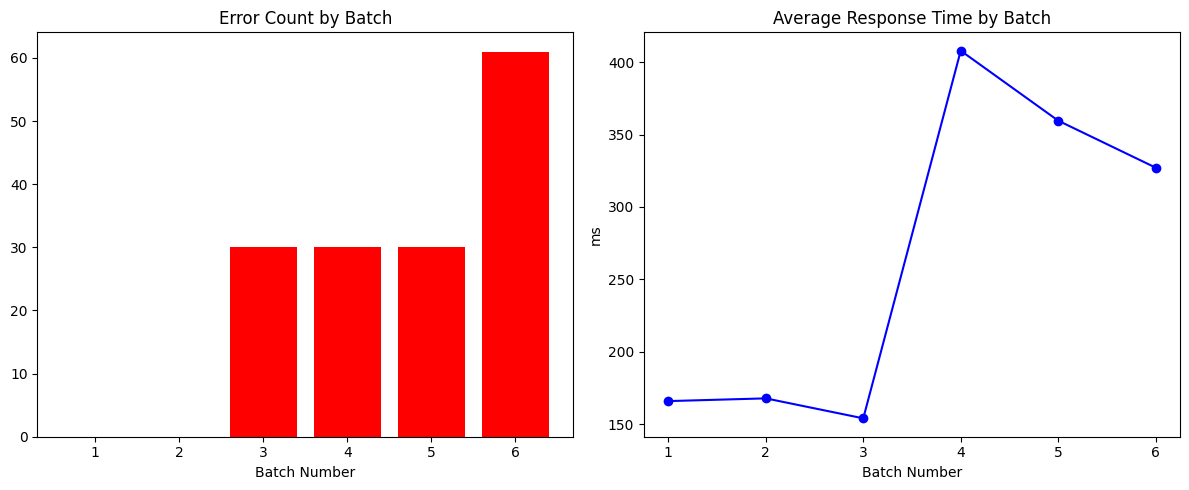


Final Metrics:
   batch  errors  avg_response
0      1       0    165.900000
1      2       0    167.790000
2      3      30    153.993333
3      4      30    407.895000
4      5      30    359.596000
5      6      61    327.146667


In [27]:
# 8. Visualization
df = pd.DataFrame(metrics)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(df["batch"], df["errors"], color="red")
plt.title("Error Count by Batch")
plt.xlabel("Batch Number")

plt.subplot(1, 2, 2)
plt.plot(df["batch"], df["avg_response"], marker="o", color="blue")
plt.title("Average Response Time by Batch")
plt.xlabel("Batch Number")
plt.ylabel("ms")

plt.tight_layout()
plt.show()

print("\nFinal Metrics:")
print(df)

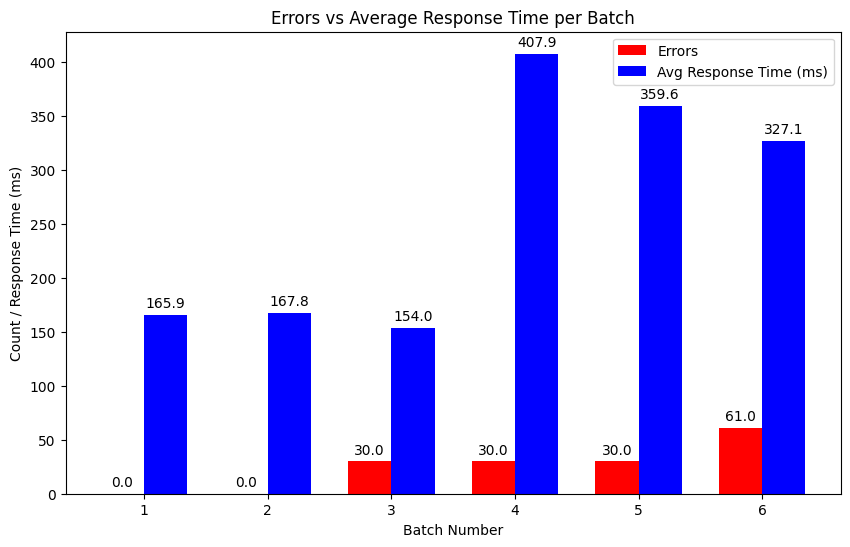

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Convert metrics list to DataFrame
df = pd.DataFrame(metrics)

# Set positions and width for bars
x = np.arange(len(df['batch']))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))

# Plot errors bars
bars1 = ax.bar(x - width/2, df['errors'], width, label='Errors', color='red')

# Plot avg response time bars
bars2 = ax.bar(x + width/2, df['avg_response'], width, label='Avg Response Time (ms)', color='blue')

# Labels and title
ax.set_xlabel('Batch Number')
ax.set_ylabel('Count / Response Time (ms)')
ax.set_title('Errors vs Average Response Time per Batch')
ax.set_xticks(x)
ax.set_xticklabels(df['batch'])
ax.legend()


def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.show()
